# Exercise 7: ARIMAX versus ARDL models

**_Group: Ducray, Razanajatovo_**

<br/>
<div style="text-align: justify">Please find below our empirical work regarding BNP's 5Y CDS forecast. The goal of this exercise is to build an alternative model using relevant explanatory variables to forecast quarterly CDS returns.</div> 
<br/>
<div style="text-align: justify">Note that the study breaks in 4 main steps: data preparation; testing ARIMA, ARCH and GARCH processes; fitting ARIMAX and ARDL models and forecast 6-steps ahaead; conclude on the best model using model analysis and RMSE computation.</div> 

## Step 1: Prepare data and review assumptions

In [1]:
#================== Import Libraries ===================

import numpy as np
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

!pip install arch
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
import statsmodels.stats.diagnostic as dg
from statsmodels import tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from itertools import product

from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

import warnings
warnings.filterwarnings("ignore")

In [2]:
#================== Load and prepare data ===================

# Load and sort chronologically data
df = pd.read_excel('BNP_CDS.xlsx', index_col=0)
df = df.sort_values(by='Date', ascending=True)

# Compute the log continuous returns 
df_logret = np.log(df['Last Price'].iloc[1:]).diff().dropna()
df_quarterly = df_logret.resample('Q').sum() #== because log returns are additive

# Split data into train (from 01/01/2010 until 31/03/2022) and test (01/04/2022 until 30/09/2022) dataframes:
df_train = df_quarterly.loc['2010-03-31' : '2021-03-31']
df_test = df_quarterly.loc['2021-06-30' : '2022-09-30']

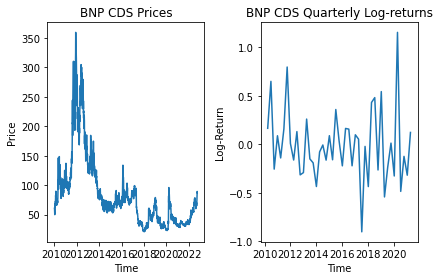

In [3]:
#================== Visual representation ===================

# Check the CDS price's fluctuation
plt.subplot(1, 2, 1)
plt.plot(df['Last Price'])
plt.title("BNP CDS Prices")
plt.xlabel('Time')
plt.ylabel('Price')
# Check the evolution of log-returns
plt.subplot(1, 2, 2)
plt.plot(df_train)
plt.title("BNP CDS Quarterly Log-returns")
plt.xlabel('Time')
plt.ylabel('Log-Return')
plt.tight_layout()

In [4]:
#================== Stationary Assumption Test: Augmented Dickey-Fuller ===================

# Run ADF test and present outputs in a straightforward dataframe
test = adfuller(df_train)
df_adf = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['Output'])
df_adf['Output']['Test Statistic Value'] = test[0]
df_adf['Output']['p-value'] = test[1]
df_adf['Output']['Lags Used'] = test[2]
df_adf['Output']['Number of Observations Used'] = test[3]
df_adf['Output']['Critical Value(1%)'] = test[4]['1%']
df_adf['Output']['Critical Value(5%)'] = test[4]['5%']
df_adf['Output']['Critical Value(10%)'] = test[4]['10%']
df_adf

,Output
Test Statistic Value,-4.904038
p-value,0.000034
Lags Used,3
Number of Observations Used,41
Critical Value(1%),-3.600983
Critical Value(5%),-2.935135
Critical Value(10%),-2.605963


<div style="text-align: justify">The null hypothesis is rejected since the test's p-value is below the 1% threshold. Therefore, the process is <strong>stationary</strong> and data's properties are fit for forecasting inference.</div> 

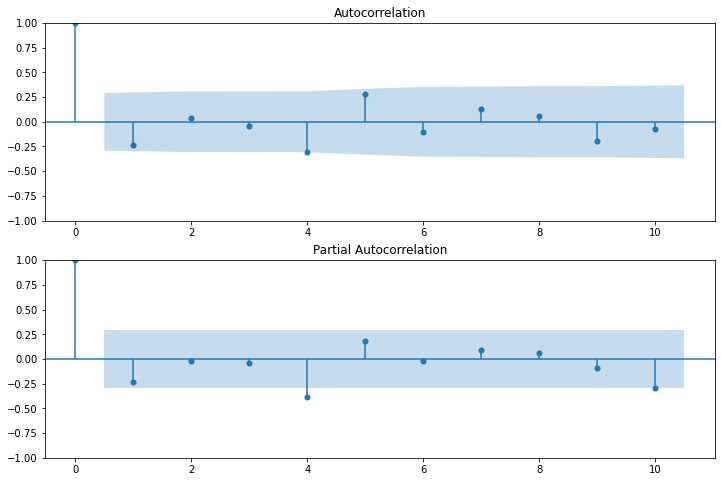

In [5]:
#================== Graphical overview: ACF/PACF Analysis ===================

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train, lags=10, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train, lags=10, ax=ax2) 

## Step 2: Specify and forecast CDS value with an ARIMA process

In [6]:
#================== Box-Jenkins Method to fit ARIMA process ===================

# Identification: Choose appropriate parameters orders based on above ACF/PACF and below AIC/BIC criterions 
ar_order = [0, 1, 2, 3, 4, 5]
ma_order = [0, 1, 2, 3, 4, 5]
arma_res = [list(orders) for orders in product(ar_order, ma_order)]

# Estimation: Fit ARMA model on train dataset
for n in arma_res:
    print('fitting: ar:{} - ma:{}'.format(*n)) 
    try:
        arma_model  = tsa.arima.model.ARIMA(df_train, order= (n[0], 0, n[1])).fit()
        # Diagnostic: Compute and analyze the information criterion + Stationarity confirmed previously 
        n.extend([arma_model.aic / 1e3, arma_model.bic / 1e3])
    except Exception as exception:
        print(exception.__str__())
        n.extend([np.NaN, np.NaN])
    
res = pd.DataFrame(arma_res, columns = ['ar_order', 'ma_order', 'aic', 'bic'])
print('criterion\n', res)

fitting: ar:0 - ma:0
fitting: ar:0 - ma:1
fitting: ar:0 - ma:2
fitting: ar:0 - ma:3
fitting: ar:0 - ma:4
fitting: ar:0 - ma:5
fitting: ar:1 - ma:0
fitting: ar:1 - ma:1
fitting: ar:1 - ma:2
fitting: ar:1 - ma:3
fitting: ar:1 - ma:4
fitting: ar:1 - ma:5
fitting: ar:2 - ma:0
fitting: ar:2 - ma:1
fitting: ar:2 - ma:2
fitting: ar:2 - ma:3
fitting: ar:2 - ma:4
fitting: ar:2 - ma:5
fitting: ar:3 - ma:0
fitting: ar:3 - ma:1
fitting: ar:3 - ma:2
fitting: ar:3 - ma:3
fitting: ar:3 - ma:4
fitting: ar:3 - ma:5
fitting: ar:4 - ma:0
fitting: ar:4 - ma:1
fitting: ar:4 - ma:2
fitting: ar:4 - ma:3
fitting: ar:4 - ma:4
fitting: ar:4 - ma:5
fitting: ar:5 - ma:0
fitting: ar:5 - ma:1
fitting: ar:5 - ma:2
fitting: ar:5 - ma:3
fitting: ar:5 - ma:4
fitting: ar:5 - ma:5
criterion
     ar_order  ma_order       aic       bic
0          0         0  0.041341  0.044954
1          0         1  0.040809  0.046229
2          0         2  0.042723  0.049949
3          0         3  0.042663  0.051697
4          0      

In [7]:
# Confirm the optimal order chosen using AIC
select_order = sm.tsa.arma_order_select_ic(df_train,max_ar=5,max_ma=5,ic='aic')['aic_min_order']
print(f"The optimal order is: {select_order}")

The optimal order is: (4, 1)


<div style="text-align: justify">We identify ARMA(4,1) as the best specification according to both AIC and BIC criterion. Since the process is stationary, our study and forecast will pursue with an <strong>ARIMA(4,0,1) process</strong>.</div>

Text(0.5, 1.0, 'Squared Residuals ACF')

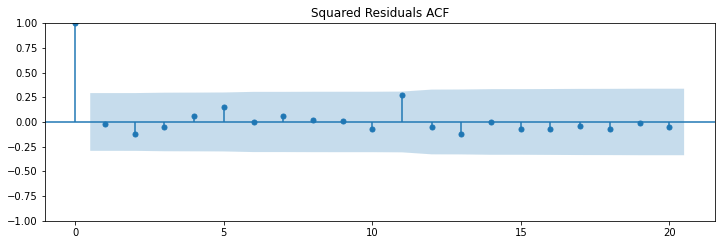

In [8]:
#===== Analyze for ARCH effects using the Ljung-Box test on the squared residuals =======================

df_train_res = df_train - np.mean(df_train)
sq_df_train_res = df_train_res**2

# Analyze squared residuals ACF & infer on ARCH effect
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sq_df_train_res, lags=20, ax=ax1)
plt.title("Squared Residuals ACF")

<div style="text-align: justify">According to the above ACF, squared residuals display no significant serial correlation. Thus, the <strong>null hypothesis is rejected</strong> and the error term doesn't present characteristics of an ARCH process.</div>

In [9]:
#===== Analyze for GARCH effects using the Jarque-Bera test on the standardized residuals =======================

# Compute standardized residuals
df_train_res = (df_train - np.mean(df_train)) / np.std(df_train)
nb_obs = len(df_train_res)

# Run Jarque-Bera normality test to check for non-linearity
jb = sm.stats.stattools.jarque_bera(df_train_res, axis=0)
df_jb = pd.DataFrame(index=['T-stat', "P-value", "Skewness", "Kurtosis"],columns=['Output'])
df_jb['Output']['T-stat'] = jb[0]
df_jb['Output']['P-value'] = jb[1]
df_jb['Output']['Skewness'] = jb[2]
df_jb['Output']['Kurtosis'] = jb[3]
df_jb

,Output
T-stat,7.302026
P-value,0.025965
Skewness,0.703938
Kurtosis,4.38286


<div style="text-align: justify">The Jarque-Bera tests the model's goodness-of-fit and indicates on its distribution. Since the p-value is above the 1% threshold, we <strong>can't reject the null hypothesis</strong> of residuals' normal distribution. Therefore, we confirm the absence of a GARCH process.</div>

In [10]:
#===== Fit and forecast data using ARIMA(4,0,1) =======================

#from statsmodels.tsa.arima_model import ARIMA
#### Other package that allows to see the confidence interval while plotting the forecast
#arma_model  = ARIMA(df_train, order=(4,0,1)).fit()
#arma_model.summary()

#### Old code suggested by Queen Ariane. Very good and efficient but no confidence interval rn
arma_model  = tsa.arima.model.ARIMA(df_train, order=(4,0,1)).fit()
arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Last Price   No. Observations:                   45
Model:                 ARIMA(4, 0, 1)   Log Likelihood                 -12.740
Date:                Sun, 25 Dec 2022   AIC                             39.480
Time:                        21:18:49   BIC                             52.127
Sample:                    03-31-2010   HQIC                            44.195
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0103      0.034     -0.306      0.759      -0.076       0.056
ar.L1         -0.7981      0.322     -2.481      0.013      -1.429      -0.168
ar.L2         -0.2061      0.251     -0.823      0.411      -0.697       0.285
ar.L3         -0.1818      0.219     -0.828      0.407      -0.612       0.248
ar.L4         -0.4315      0.150     -2.878      0.004      -0.725      -0.138
ma.L1          0.6998      0.340      2.057      0.040       0.033       1.367
sigma2         0.0998      0.022      4.533      0.000       0.057       0.143
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.23
Prob(Q):                              0.97   Prob(JB):                         0.89
Heteroskedasticity (H):               1.05   Skew:                             0.08
Prob(H) (two-sided):                  0.92   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ar.L1, ar.L4 and ma.L1 coefficient are significant (with p-value below 0.05)

In [11]:
# Forecast
#forecast_arma, std_error, IC = arma_model.forecast(6, alpha=0.05)
forecast_arma = arma_model.forecast(6)

# Prepare the series to plot training, forecast and acutal data 
#fc_series = pd.Series(forecast_arma, index=df_test.index)
#lower_series = pd.Series(IC[:, 0], index=df_test.index)
#upper_series = pd.Series(IC[:, 1], index=df_test.index)

# If you need to check the forecasted data
forecast_arma = pd.DataFrame({'Projected return' : forecast_arma})
forecast_arma 

# Graph comparison of forecasts vs. actual data
#plt.figure(figsize=(12,8)) # If you add ", dpi=100" you have a wider plot
#plt.plot(df_train, label='training')
#plt.plot(df_test, label='actual')
#plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.15)
#plt.title('Forecast vs Actuals')
#plt.legend(loc='upper left', fontsize=8)
#plt.show()

,Projected return
2021-06-30,0.527999
2021-09-30,-0.361628
2021-12-31,0.268215
2022-03-31,-0.315108
2022-06-30,0.007123
2022-09-30,0.139525


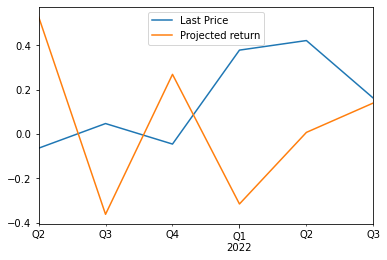

In [12]:
#===== Graphical analysis to compare forecasts vs. real values =======================

output = pd.concat([df_test, forecast_arma['Projected return']], axis=1)
output.plot()
plt.show()

## Step 3: Build an Atlernative Model

<div style="text-align: justify">Our quarterly CDS returns study and additional forecast deal with 5 exogenous explanatory variables downloaded from Bloomberg:</div>

<div>
  <ul>
    <li>Euribor 3 months Index</li>
    <li>CAC40 Index</li>
    <li>EURUSD Curncy</li>
    <li>ECB Main Refinancing Operations Rate</li>
    <li>BNP FP Equity</li>
  </ul>
</div>

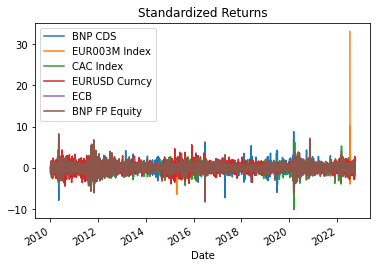

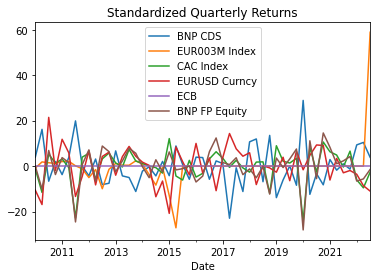

In [13]:
#================== Load and prepare data ===================

# Load and sort chronologically data
df_2 = pd.read_excel('Variables.xlsx', index_col=0).dropna()
df_2 = df_2.sort_values(by='Date', ascending=True)

# Compute standardized log-returns to correct for the scale effect
df_returns = np.log(df_2).diff()
df_returns_std = (df_returns - np.mean(df_returns)) / np.std(df_returns)
# Compute quarterly returns
df_returns_quarterly = df_returns_std.resample('Q').sum()

# Visual representation 
df_returns_std.plot()
plt.title("Standardized Returns")
df_returns_quarterly.plot()
plt.title("Standardized Quarterly Returns")

# Split data into train (from 01/01/2010 until 31/03/2022) and test (01/04/2022 until 30/09/2022) dataframes:
df2_train = df_returns_quarterly.loc['2010-03-31' : '2021-03-31']
df2_test = df_returns_quarterly.loc['2021-06-30' : '2022-09-30']

### The ARIMAX alternative
</br>
<div style="text-align: justify">This subsection is constructed in the Box-Jenkins approach to fit and forecast BNP CDS' data. Eventually we will measure the accuracy of the forecast plotting against the real values and computing the RMSE.</div>   

In [14]:
#================== Stationary Assumption Test: Augmented Dickey-Fuller  ===================

# Function to run ADF test and return an ordered dataframe -> Ease output reading and understanding
def adf_outputs(df):
    test = adfuller(df)
    df_adf = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=[df.name])
    df_adf[df.name]['Test Statistic Value'] = test[0]
    df_adf[df.name]['p-value'] = test[1]
    df_adf[df.name]['Lags Used'] = test[2]
    df_adf[df.name]['Number of Observations Used'] = test[3]
    df_adf[df.name]['Critical Value(1%)'] = test[4]['1%']
    df_adf[df.name]['Critical Value(5%)'] = test[4]['5%']
    df_adf[df.name]['Critical Value(10%)'] = test[4]['10%']
    return df_adf

# Merge all the outputs to have summary table for ADF tests
list = [df2_train['CAC Index'],df2_train['EURUSD Curncy'], df2_train['ECB'], df2_train['BNP FP Equity']]
adf_summary = adf_outputs(df2_train['EUR003M Index'])
for i in range(len(list)):
    adf_summary = pd.merge(adf_summary, adf_outputs(list[i]), left_index=True, right_index=True)

adf_summary

,EUR003M Index,CAC Index,EURUSD Curncy,ECB,BNP FP Equity
Test Statistic Value,-4.51906,-8.137827,-7.060095,NaN,-8.115436
p-value,0.000182,0.0,0.0,NaN,0.0
Lags Used,0,0,0,0,0
Number of Observations Used,44,44,44,44,44
Critical Value(1%),-3.588573,-3.588573,-3.588573,-3.588573,-3.588573
Critical Value(5%),-2.929886,-2.929886,-2.929886,-2.929886,-2.929886
Critical Value(10%),-2.603185,-2.603185,-2.603185,-2.603185,-2.603185


<div style="text-align: justify">According to ADF p-values, for each time series, we can reject the null of unit root presence. The processes are thus <strong>stationary</strong> and there is no need for differenciation nor de-trending.</div>

In [15]:
#========= Fitting an ARIMAX model =================

# We fit the ARIMA model keeping the optimal parameters computed above for ARIMA
arimax_model  = tsa.arima.model.ARIMA(endog=df2_train['BNP CDS'],
                                      exog=df2_train[['EUR003M Index','CAC Index','EURUSD Curncy','ECB','BNP FP Equity']],
                                            order=(4,0,1)).fit()
arimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                BNP CDS   No. Observations:                   45
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -136.779
Date:                Sun, 25 Dec 2022   AIC                            297.559
Time:                        21:18:52   BIC                            319.239
Sample:                    03-31-2010   HQIC                           305.641
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.4827      0.573     -0.842      0.400      -1.606       0.640
EUR003M Index    -0.0272      0.150     -0.182      0.856      -0.321       0.266
CAC Index        -0.5164      0.451     -1.145      0.252      -1.400       0.368
EURUSD Curncy    -0.1557      0.145     -1.075      0.283      -0.440       0.128
ECB                    0   1.27e-06          0      1.000   -2.49e-06    2.49e-06
BNP FP Equity    -0.4143      0.357     -1.162      0.245      -1.113       0.285
ar.L1            -0.2831      0.625     -0.453      0.650      -1.507       0.941
ar.L2            -0.2014      0.219     -0.920      0.357      -0.630       0.228
ar.L3            -0.2599      0.264     -0.983      0.326      -0.778       0.258
ar.L4            -0.4235      0.254     -1.665      0.096      -0.922       0.075
ma.L1            -0.0039      0.738     -0.005      0.996      -1.450       1.442
sigma2           25.0384      5.567      4.497      0.000      14.127      35.950
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.80
Prob(Q):                              0.99   Prob(JB):                         0.02
Heteroskedasticity (H):               1.36   Skew:                            -0.61
Prob(H) (two-sided):                  0.55   Kurtosis:                         4.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.01e+19. Standard errors may be unstable.
"""

In [16]:
#========= Forecast 6-step ahead using the ARIMAX model =================

forecast_arimax = arimax_model.forecast(6, exog=df2_test[['EUR003M Index','CAC Index','EURUSD Curncy','ECB','BNP FP Equity']])
forecast_arimax = pd.DataFrame({'Projected return' : forecast_arimax})
forecast_arimax

,Projected return
2021-06-30,-5.336528
2021-09-30,-1.394989
2021-12-31,-9.419207
2022-03-31,3.724801
2022-06-30,10.338851
2022-09-30,2.778673


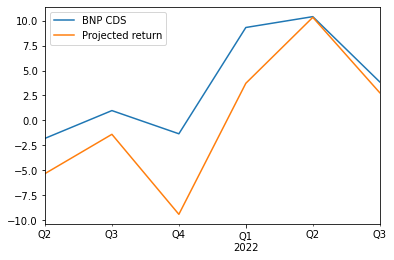

In [17]:
#========= Graphical comparison: forecast vs. real values =================

output2 = pd.concat([df2_test['BNP CDS'], forecast_arimax['Projected return']], axis=1)
output2.plot()
plt.show()

### The ARDL alternative
</br>
<div style="text-align: justify">This subsection follows the same construction as the ARIMAX one. After a Box-Jenkins approach, we will focus on the forecast's accuracy, the model's relevant use for this time series, and compute the RMSE to select the best model. </div>   

In [18]:
#========= Box-Jenkins Method to fit ARDL process =================

# Identification & Diagnostic: Computing the optimal parameter orders for the ARDL based on information criterion
opti_param = ardl_select_order(endog = df2_train['BNP CDS'], maxlag = 5, exog = df2_train[['EUR003M Index','CAC Index','EURUSD Curncy','ECB','BNP FP Equity']], trend="c", maxorder = 5, ic="aic")
print(f"The optimal order is: {opti_param.model.ardl_order}")

The optimal order is: (5, 1, 5, 4)


In [19]:
# Estimation: Fit ARDL model on train dataset
ardl_model = opti_param.model.fit()
ardl_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                BNP CDS   No. Observations:                   45
Model:               ARDL(5, 1, 5, 4)   Log Likelihood                -108.760
Method:               Conditional MLE   S.D. of innovations              3.670
Date:                Sun, 25 Dec 2022   AIC                            257.520
Time:                        21:19:10   BIC                            291.298
Sample:                    06-30-2011   HQIC                           269.733
                         - 03-31-2021                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.1892      1.104     -2.890      0.009      -5.484      -0.894
BNP CDS.L1          -0.3654      0.167     -2.182      0.041      -0.714      -0.017
BNP CDS.L2           0.0480      0.173      0.277      0.784      -0.311       0.407
BNP CDS.L3          -0.0566      0.166     -0.342      0.736      -0.401       0.288
BNP CDS.L4          -0.5548      0.157     -3.528      0.002      -0.882      -0.228
BNP CDS.L5          -0.1461      0.133     -1.100      0.284      -0.422       0.130
EUR003M Index.L0    -0.1746      0.237     -0.737      0.469      -0.667       0.318
EUR003M Index.L1    -0.5309      0.242     -2.198      0.039      -1.033      -0.029
EURUSD Curncy.L0    -0.2099      0.133     -1.580      0.129      -0.486       0.066
EURUSD Curncy.L1     0.0398      0.170      0.234      0.817      -0.313       0.393
EURUSD Curncy.L2     0.3110      0.173      1.802      0.086      -0.048       0.670
EURUSD Curncy.L3     0.3168      0.137      2.313      0.031       0.032       0.602
EURUSD Curncy.L4     0.0813      0.126      0.645      0.526      -0.181       0.343
EURUSD Curncy.L5    -0.3184      0.117     -2.722      0.013      -0.562      -0.075
BNP FP Equity.L0    -0.7429      0.117     -6.350      0.000      -0.986      -0.500
BNP FP Equity.L1    -0.1715      0.169     -1.013      0.323      -0.524       0.181
BNP FP Equity.L2    -0.0901      0.179     -0.503      0.620      -0.463       0.283
BNP FP Equity.L3    -0.2949      0.178     -1.658      0.112      -0.665       0.075
BNP FP Equity.L4    -0.7954      0.184     -4.329      0.000      -1.177      -0.413
====================================================================================
"""

In [20]:
#========= Forecast 6-step ahead using the ARDL model =================

forecast_ardl = ardl_model.forecast(6, exog=df2_test[['EUR003M Index','CAC Index','EURUSD Curncy','ECB','BNP FP Equity']])
forecast_ardl = pd.DataFrame({'Projected return' : forecast_ardl})
forecast_ardl

,Projected return
2021-06-30,-6.791434
2021-09-30,1.996478
2021-12-31,-19.823224
2022-03-31,-1.337203
2022-06-30,5.366130
2022-09-30,-15.986499


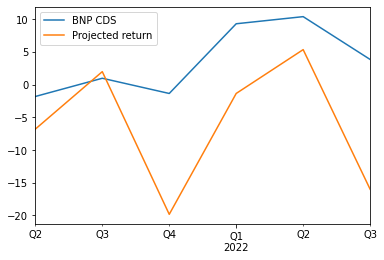

In [21]:
#========= Graphical comparison: forecast vs. real values =================

output3 = pd.concat([df2_test['BNP CDS'], forecast_ardl['Projected return']], axis=1)
output3.plot()
plt.show()

## 3. Model Analysis and Selection
</br>
<div style="text-align: justify">In this section we compare both models, their pros and cons, and most importantly their Root Mean Squared Error (RMSE) to select the best model.</div>

In [22]:
#========= Compute RMSE before infering ===============


# Define Actual and Predicted Array
actual_arima = output2['BNP CDS']
pred_arima = output2['Projected return']
actual_ardl = output3['BNP CDS']
pred_ardl = output3['Projected return']

# Calculate RMSE
result_arima = sqrt(mean_squared_error(actual_arima,pred_arima))
result_ardl = sqrt(mean_squared_error(actual_ardl,pred_ardl))

# Compare both values and display results accordingly
if result_arima > result_ardl:
    print(f'Our ARDL model has the best fit for BNP CDS data with a {result_ardl} RMSE compared to ARIMA and its {result_arima} RMSE.')
elif result_arima < result_ardl:
    print(f'Our ARMIA model has the best fit for BNP CDS data with a {result_arima} RMSE, compared to ARDL and its {result_ardl} RMSE.')
else:
    print(f"Both model have the same RMSE of {result_ardl}. Therefore, our analysis and model selection will focus on models' pros & cons to further infer.")

Our ARMIA model has the best fit for BNP CDS data with a 4.395786478166975 RMSE, compared to ARDL and its 12.251296142560204 RMSE.
